# Segmentation Algorithm Demo for Centrin (CENT2)

----------------------------------------
description of the structure 

----------------------------------------

Also, we may add a picture of the corresponding row in the lookup table for readers to correlate this notebook with a specifc row in the lookup table.


----------------------------------------
PLACEHOLDER: description of the functions to be used, and the usage of each parameters

----------------------------------------


In [2]:
import numpy as np

# package for 3d visualization
from itkwidgets import view                              
from aicssegmentation.core.visual import seg_fluo_side_by_side,  single_fluorescent_view, segmentation_quick_view
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16, 12]

# package for io 
from aicsimageio import AICSImage, omeTifWriter                            

# function for core algorithm
from aicssegmentation.core.seg_dot import dot_3d  
from aicssegmentation.pre_processing_utils import intensity_normalization, image_smoothing_gaussian_slice_by_slice
from skimage.morphology import remove_small_objects, watershed, dilation, erosion, ball     # function for post-processing (size filter)
from skimage.feature import peak_local_max
from skimage.measure import label
from scipy.ndimage import distance_transform_edt
from aicssegmentation.core.visual import explore_dot_3d

ImportError: No module named '_czifile'. Decoding of JXR and JPEG encoded images will not be available. Czifile.pyx can be obtained at http://www.lfd.uci.edu/~gohlke/


## Loading the data

In [4]:
FILE_NAME = '/allen/aics/assay-dev/Segmentation/documentation/toolkit_paper/structures/CETN2/original/3500001598_100X_20171222_4-Scene-07-P42-F06.czi'

reader = AICSImage(FILE_NAME) 
IMG = reader.data

print(IMG.shape)

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


(1, 7, 60, 624, 924)


## Preview of the image

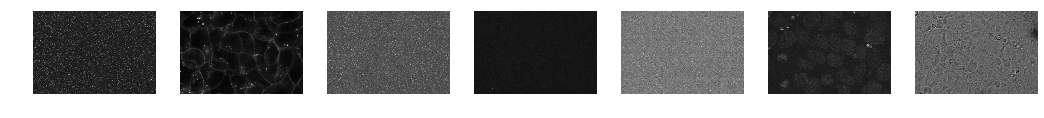

In [5]:
N_CHANNELS = IMG.shape[1]
MID_SLICE = np.int(0.5*IMG.shape[2])

fig, ax = plt.subplots(1, N_CHANNELS, figsize=(18,16), dpi=72, facecolor='w', edgecolor='k')
for channel in range(N_CHANNELS):
    ax[channel].axis('off')
    ax[channel].imshow(IMG[0,channel,MID_SLICE,:,:], cmap=plt.cm.gray)

## Image segmentation

### Step 1: Pre-Processing

In [6]:
################################
## PARAMETERS for this step ##
structure_channel = 3
gaussian_smoothing_sigma = 1
intensity_scaling_param = [8000] 
# For intensity_scaling_param, a single value K means cutoff all intensity over K 
# and do min-max normalization after that. 8000 is related to our imaging setting.
# Usually, the intensity is around 2000. 8000 is set in a conservative manner just 
# in case some dead pixel (intensity = 65535)
################################

structure_img = IMG[0,structure_channel,:,:,:]

# intensity normalization
structure_img = intensity_normalization(structure_img, scaling_param=intensity_scaling_param)

# smoothing with 2d gaussian filter slice by slice 
structure_img_smooth = image_smoothing_gaussian_slice_by_slice(structure_img, sigma=gaussian_smoothing_sigma)

intensity normalization: using min-max normalization with absolute intensity upper bound 8000
intensity normalization completes


In [9]:
view(single_fluorescent_view(structure_img_smooth))

Viewer(rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkImageF3 *' at 0x7f5ab470bd…

### Step 2: Core Algorithm

#### step 2.1: laplacian of gaussian filter (Run with default parameters as in Look-up Table)

In [10]:
################################
## PARAMETERS for this step ##
dot_3d_sigma = 1
dot_3d_cutoff = 0.04
################################

bw = dot_3d(structure_img_smooth, log_sigma=dot_3d_sigma) > dot_3d_cutoff

In [11]:
view(segmentation_quick_view(bw))

Viewer(rendered_image=<itkImagePython.itkImageUC3; proxy of <Swig Object of type 'itkImageUC3 *' at 0x7f5a7c27…

In [12]:
# Find a region of interest (ROI) in segmentation image above, and then type in ROI below
# in the form of [Upper_Left_X, Upper_Left_Y, Lower_right_X, Lower_right_Y]
ROI = [574,366, 681,448]
view(seg_fluo_side_by_side(structure_img,response>0.04,roi=ROI))

# or comment out the following line to see the whole FOV
#view(seg_fluo_side_by_side(structure_img,seg))

Viewer(rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkImageF3 *' at 0x7fbaa59502…

#### If the segmentation is satisfactory (note: step 2.2 can further cut touching spots), go to Step 2.2; otherwise, you can tune parameters to improve the performance. Follow the steps below:

--------------------------
Placeholder:  Describe the effect of each parameter

------------------------------

In [14]:
# find a small region of interest, 
# type in below the coordinates of upper left corner and lower right corner of the ROI
# in the form of [Upper_Left_X, Upper_Left_Y, Lower_right_X, Lower_right_Y]
ROI = [688, 547, 792,622]
view(explore_dot_3d(structure_img_smooth, sigma=0.1, th=0.5, roi=ROI))

Viewer(rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkImageF3 *' at 0x7fa1903fff…

#### Now, if you have found a satisfatory set of parameters, type in the parameters below and re-run the segmentation. Then, move to step 3

In [16]:
# type in parameters here:
dot_3d_sigma = 1
dot_3d_cutoff = 0.015

response = dot_3d(structure_img_smooth, log_sigma=dot_3d_sigma)
bw = response > dot_3d_cutoff


#### step 2.2: Perform local maximum and watershed to further separate touchign sports

In [18]:
minArea = 4
local_maxi = peak_local_max(structure_img,labels=label(remove_small_objects(bw>0, min_size=minArea, connectivity=1, in_place=False)), min_distance=2, indices=False)
distance = distance_transform_edt(bw)
seg = watershed(-distance, label(dilation(local_maxi,selem=ball(1))), mask=bw, watershed_line=True)

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


#### Step 3: Post-Processing 

In [19]:
################################
## PARAMETERS for this step ##
minArea = 4
################################

final_seg = remove_small_objects(seg>0, min_size=minArea, connectivity=1, in_place=False)

## Result inspection

In [17]:
view(seg_fluo_side_by_side(structure_img,SEG))

Viewer(rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkImageF3 *' at 0x7f2b44072c…

### You can also focus your inspection on a small ROI

In [ ]:
# Find ROI in segmentation image above (not the raw image on the right part), and then type in ROI below
# in the form of [Upper_Left_X, Upper_Left_Y, Lower_right_X, Lower_right_Y]
ROI = [244, 361, 441, 562]
view(seg_fluo_side_by_side(structure_img,SEG, roi=ROI))

### You may also physically save the segmentation results into a ome.tif file

In [27]:
SEG= SEG>0
out=SEG.astype(np.uint8)
out[out>0]=255
writer = omeTifWriter.OmeTifWriter('/allen/aics/assay-dev/Segmentation/documentation/toolkit_paper/structures/DSP/test1.ome.tif')
writer.save(out)